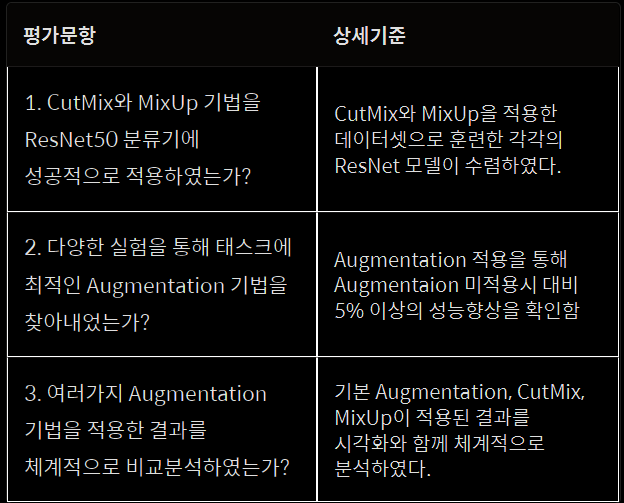

# 0. Libraries and Dataset

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from PIL import Image

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow_datasets as tfds

print("Tensorflow Version: ",tf.__version__)
print("Numpy Version: ",np.__version__)

Tensorflow Version:  2.6.0
Numpy Version:  1.21.4


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

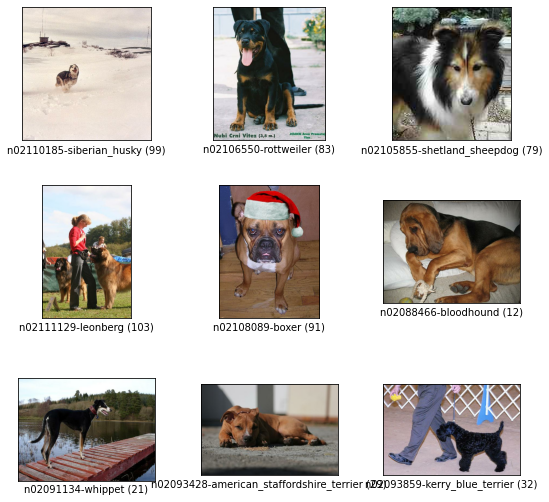

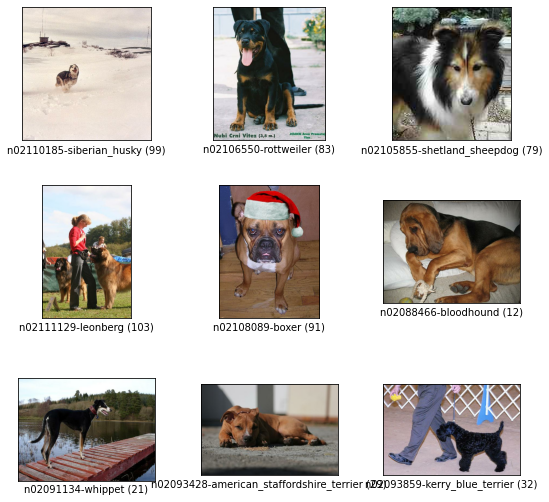

In [4]:
tfds.show_examples(ds_train, ds_info)

# 1. Augmentation을 적용한 데이터셋 만들기   

## 1-1. Cutmix   
이미지의 일정영역(bounding box)을 잘라서 다른 이미지에 붙여주는 방법

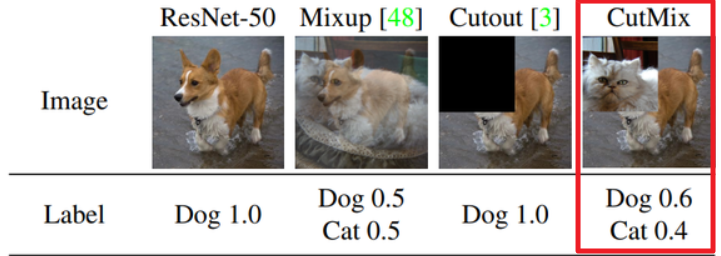

● 위 그림과 같이 batch 내의 image 두 개를 골라서 섞음   
● bounding box : 잘러서 썩어주는 영역

In [5]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

# mix two images
# image_a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수를 구현
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

# mix two labels
# 섞인 이미지 두 가지에 대하여 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수를 구현
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):

    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):

    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## 1-2. Mixup   
이미지의 일정영역(bounding box)을 잘라서 다른 이미지에 붙여주는 방법

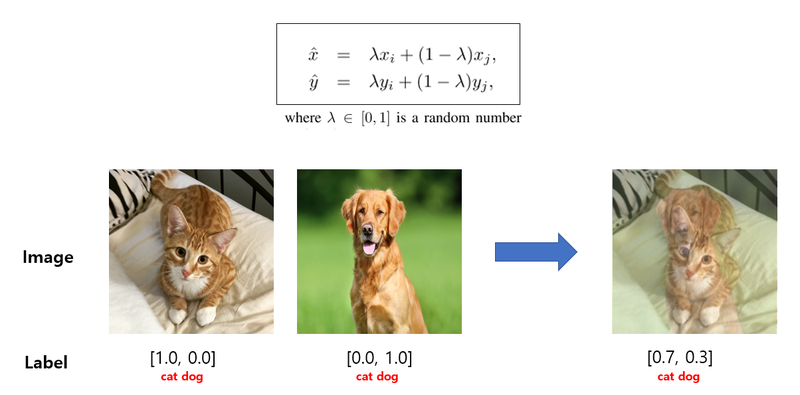

In [6]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


# 2. 모델 만들기    
앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

## 2-1. Dataset 전처리

In [7]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

# def onehot(image,label):
#     image = tf.clip_by_value(image, 0, 1)
#     return image, label

def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    onehot_imgs = []
    onehot_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        if len(label_a.shape)==0:
            label_a = tf.one_hot(label_a, num_classes)

        onehot_imgs.append(image_a)
        onehot_labels.append(label_a)

    onehot_imgs = tf.reshape(tf.stack(onehot_imgs),(batch_size, img_size, img_size, 3))
    onehot_labels = tf.reshape(tf.stack(onehot_labels),(batch_size, num_classes))
    return onehot_imgs, onehot_labels

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## 2-2. 학습모델

In [8]:
num_classes = ds_info.features["label"].num_classes

# 기본 ResNet-50 학습모델
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=True,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])


# 기본 ResNet-50 학습모델(좌우대칭 및 밝기)
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=True,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

102981632/102967424 [==============================] - 0s 0us/step


In [9]:
# Mixup 학습모델
mixup_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=True,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')

])


# Cutmix 학습모델
cutmix_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=True,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')

])
print('=3')

=3


In [10]:
mixup_aug_resnet50.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1000)              25636712  
_________________________________________________________________
dense_2 (Dense)              (None, 120)               120120    
Total params: 25,756,832
Trainable params: 25,703,712
Non-trainable params: 53,120
_________________________________________________________________


In [11]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True,with_cutmix=False) # augmentation
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=False,with_mixup=True) # mixup 추가 및 augmentation
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=False,with_cutmix=True) # cutmix 추가 및 augmentation
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')

=3


# 3. 모델 훈련하기

In [12]:
EPOCH = 20
BATCH_SIZE = 16

In [13]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 195s 207ms/step - loss: 4.7840 - accuracy: 0.0278 - val_loss: 4.7860 - val_accuracy: 0.0192
Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 4.7725 - accuracy: 0.0929 - val_loss: 4.7625 - val_accuracy: 0.1662
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 4.7564 - accuracy: 0.2002 - val_loss: 4.7433 - val_accuracy: 0.2740
Epoch 4/20
750/750 [==============================] - 169s 225ms/step - loss: 4.7366 - accuracy: 0.2940 - val_loss: 4.7203 - val_accuracy: 0.3644
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 4.7121 - accuracy: 0.3727 - val_loss: 4.6938 - val_accuracy: 0.4299
Epoch 6/20
750/750 [==============================] - 154s 205ms/step - loss: 4.6837 - accuracy: 0.4153 - val_loss: 4.6646 - val_accuracy: 0.4588
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 4.6529 - accuracy: 0.4563 - val_loss: 4.6338 -

In [14]:
# 기본 Augumentation & Mixup

mixup_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)
history_resnet50_aug_mixup = mixup_aug_resnet50.fit(
    ds_train_aug_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 162s 207ms/step - loss: 4.7869 - accuracy: 0.0099 - val_loss: 4.7872 - val_accuracy: 0.0108
Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 4.7847 - accuracy: 0.0188 - val_loss: 4.7760 - val_accuracy: 0.0659
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 4.7812 - accuracy: 0.0409 - val_loss: 4.7681 - val_accuracy: 0.1300
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 4.7763 - accuracy: 0.0814 - val_loss: 4.7579 - val_accuracy: 0.1845
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 4.7709 - accuracy: 0.1174 - val_loss: 4.7464 - val_accuracy: 0.2291
Epoch 6/20
750/750 [==============================] - 154s 205ms/step - loss: 4.7639 - accuracy: 0.1493 - val_loss: 4.7347 - val_accuracy: 0.2575
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 4.7558 - accuracy: 0.1708 - val_loss: 4.7206 -

In [15]:
# 기본 Augumentation & Cutmix

cutmix_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_cutmix = cutmix_aug_resnet50.fit(
    ds_train_aug_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 162s 206ms/step - loss: 4.7874 - accuracy: 0.0099 - val_loss: 4.7871 - val_accuracy: 0.0097
Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 4.7858 - accuracy: 0.0187 - val_loss: 4.7824 - val_accuracy: 0.0434
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 4.7840 - accuracy: 0.0325 - val_loss: 4.7778 - val_accuracy: 0.0697
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 4.7814 - accuracy: 0.0499 - val_loss: 4.7717 - val_accuracy: 0.1062
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 4.7784 - accuracy: 0.0725 - val_loss: 4.7647 - val_accuracy: 0.1311
Epoch 6/20
750/750 [==============================] - 154s 205ms/step - loss: 4.7736 - accuracy: 0.1002 - val_loss: 4.7555 - val_accuracy: 0.1891
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 4.7684 - accuracy: 0.1335 - val_loss: 4.7451 -

In [16]:
# 기본 Augmentation

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 161s 207ms/step - loss: 4.7842 - accuracy: 0.0255 - val_loss: 4.7858 - val_accuracy: 0.0202
Epoch 2/20
750/750 [==============================] - 153s 205ms/step - loss: 4.7750 - accuracy: 0.0822 - val_loss: 4.7659 - val_accuracy: 0.1389
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 4.7614 - accuracy: 0.1697 - val_loss: 4.7477 - val_accuracy: 0.2493
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 4.7428 - accuracy: 0.2568 - val_loss: 4.7253 - val_accuracy: 0.3277
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 4.7210 - accuracy: 0.3184 - val_loss: 4.7003 - val_accuracy: 0.3961
Epoch 6/20
750/750 [==============================] - 169s 225ms/step - loss: 4.6948 - accuracy: 0.3823 - val_loss: 4.6718 - val_accuracy: 0.4286
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 4.6661 - accuracy: 0.4174 - val_loss: 4.6413 -

# 4. 훈련 과정 시각화하기

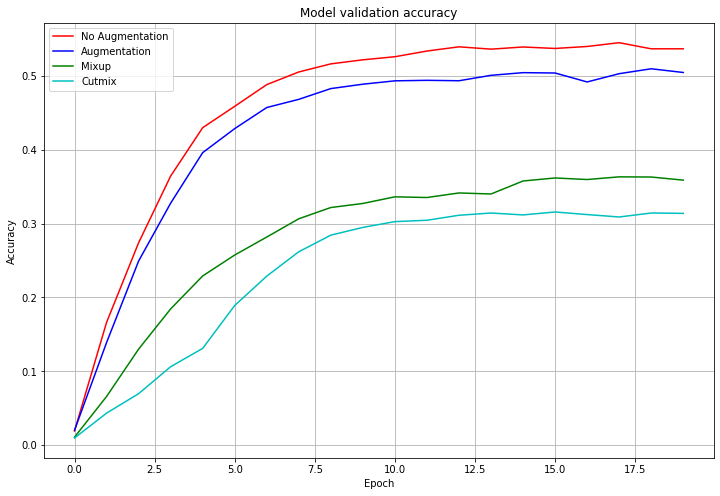

In [19]:
plt.figure(figsize=(12,8))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'c')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'Mixup', 'Cutmix'], loc='upper left')
plt.grid()
plt.show()

# 5. Augmentation에 의한 모델 성능 비교

Augmentation이 없는 학습이 가장 accuracy가 높고 그다음이 기본 Augmentation이 었다. 심화기법인 Mixup과 Cutmix가 오히려 accuracy가 떨어졌다. cutmix기법의 경우 bounding box위치가 image의 특성을 잘 나타내는 곳에 있지 않이서 제대로 된 feature 뽑아내지 못하여 효과적인학습이 불가능했으리라 생각된다.

# 6. 퇴고

Colab 오류로 AIFFEL 서버에서 학습을 진행하였다. 학습이 많은시간 소요되어서 힘들었지만 개념적 이해는 하기가 좋았다. 기본 augmentation의 기법이 내가 적용한 대칭이나 밝기 변경이외에 많이 있었지만 시간상 하지 못하여 아쉬웠다.